# 1. Introduction

#### PUBG (PlayerUnknown’s Battlegrounds) is a popular online multiplayer battle royale game developed and published by PUBG Corporation, a subsidiary of the South Korean company Krafton.

#### In PUBG, up to 100 players are dropped onto an island, where they must scavenge for weapons, armor, and resources, and then decide to either fight or hide with the ultimate goal of being the last one standing.

## 1.1. About the Dataset

#### The Dataset contains every death that occurred within about 120,000 PUBG matches. That is, each row documents an event where a player has died in the match.

#### The following is the explaination of the columns of the dataset:

- **killed_by**: Name of the weapon or game event or mechanic that killed the player (victim), such as: SCAR-L, Bluezone, or Falling.

- **killer_name**: Name of the player that killed the victim, AKA. killer, only if it's exists according to the previous value (eg. if victim died by Falling, no killer_name is provided).

- **killer_placement**: The final placement (final rank of that game) of the killer after the game was over (eg. 1 means he won the game being the last one standing).

- **killer_position_x** and **killer_position_y**: Coordinates of the killer at the moment of victim's death.

- **map**: Name of the map being played: ERANGEL or MIRAMAR.

- **match_id**: Internal ID of the match being played.

- **time**: Amount of time in seconds since the match started up until the victim's death.

- **victim_name**: Name of the victim.

- **victim_placement**: The final placement of the victim after the game was over.

- **victim_position_x** and **victim_position_y**: Coordinates of the victim at the moment of his death.

#### You can download the dataset [by clicking here](https://www.kaggle.com/datasets/skihikingkevin/pubg-match-deaths).

# 2. Data Loading and Initial Exploration

#### In this section, I am going to load the dataset and display how it looks. For the whole assignment I will be using Spark, but for visualization I will be using Pandas.

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session with all configurations at once
spark = SparkSession.builder \
    .appName("ReadCSV") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.shuffle.partitions", "500") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Set log level to ERROR to ignore most warnings for readability
spark.sparkContext.setLogLevel("ERROR")

# To optimize performance, especially when encountering issues like memory errors or large shuffle operations
spark.conf.set("spark.sql.shuffle.partitions", "1000")

24/11/07 14:10:33 WARN Utils: Your hostname, Ivans-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.2.18 instead (on interface en0)
24/11/07 14:10:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/07 14:10:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Convert CSV File into a Spark DF
df = spark.read.csv('kill_match_stats_final_4.csv', header=True, inferSchema=True)
df = df.repartition(200)

In [3]:
# Display the schema of the DataFrame
df.printSchema()

root
 |-- killed_by: string (nullable = true)
 |-- killer_name: string (nullable = true)
 |-- killer_placement: double (nullable = true)
 |-- killer_position_x: double (nullable = true)
 |-- killer_position_y: double (nullable = true)
 |-- map: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- victim_name: string (nullable = true)
 |-- victim_placement: double (nullable = true)
 |-- victim_position_x: double (nullable = true)
 |-- victim_position_y: double (nullable = true)



#### **Observations**

The dataset contains only string and double types of data, which is expected given the columns we already discussed in the introduction.

In [4]:
# Show the first 10 rows of the DataFrame
df.show(10)

+------------+--------------+----------------+-----------------+-----------------+-------+--------------------+----+--------------+----------------+-----------------+-----------------+
|   killed_by|   killer_name|killer_placement|killer_position_x|killer_position_y|    map|            match_id|time|   victim_name|victim_placement|victim_position_x|victim_position_y|
+------------+--------------+----------------+-----------------+-----------------+-------+--------------------+----+--------------+----------------+-----------------+-----------------+
|        UMP9|       wzp9931|            31.0|         579170.8|         486874.9|ERANGEL|2U4GBNA0YmkZ7PLML...| 738|      jiangjjb|            46.0|         579334.9|         486758.6|
|Down and Out|   Me_Handsome|            16.0|         192878.4|         287132.1|MIRAMAR|2U4GBNA0Ymlkz4cT0...| 443|       OuOvvvv|            19.0|         193335.8|         290566.2|
|       S1897|  CleverDragon|            14.0|         326473.6|         35

#### **Observations**

It seems every column has something of value. match_id, for instance, can be used as a group_by column to get insights for specific matches, and even the positions can be used to plot a map graph.

In [5]:
# Show unique values in column killed_by

# Collect all unique values in the 'killed_by' column
unique_killed_by = [row["killed_by"] for row in df.select("killed_by").distinct().collect()]

# Display all unique values
for value in unique_killed_by:
    print(value)

Micro UZI
Mini 14
Uaz
Falling
Tommy Gun
Hit by Car
SKS
DP-28
S686
UMP9
P18C
Crowbar
death.WeapSawnoff_C
R45
M16A4
Groza
SCAR-L
Motorbike (SideCar)
death.ProjMolotov_C
Boat
Kar98k
M249
Pickup Truck
Pan
P92
RedZone
Van
Dacia
Sickle
Machete
Bluezone
AWM
Vector
Crossbow
death.Buff_FireDOT_C
P1911
AUG
death.ProjMolotov_DamageField_C
AKM
Drown
Buggy
Grenade
Mk14
Punch
VSS
Down and Out
S1897
S12K
M24
Motorbike
Win94
M416
R1895
Aquarail
death.RedZoneBomb_C
death.PG117_A_01_C


#### **Observations**

There seems to be quite a collection of ways to die. Most of them are weapons, but there are some other types as well, such as cars, Falling, Drowning and Bluezone.

In [6]:
from pyspark.sql.functions import min, max

# List of numerical columns for which to check the range
numerical_columns = ["killer_placement", "victim_placement", "time"]

# Compute min and max values for each column
df.select([min(col).alias(f"{col}_min") for col in numerical_columns] + 
          [max(col).alias(f"{col}_max") for col in numerical_columns]).show()

+--------------------+--------------------+--------+--------------------+--------------------+--------+
|killer_placement_min|victim_placement_min|time_min|killer_placement_max|victim_placement_max|time_max|
+--------------------+--------------------+--------+--------------------+--------------------+--------+
|                 1.0|                 1.0|      33|               100.0|               100.0|    2284|
+--------------------+--------------------+--------+--------------------+--------------------+--------+



#### **Observations**

It makes sense for the placements to be an integer between 1 and 100, and it's useful to know matches takes 2,284 seconds (38 minutes) at most.

In [7]:
# Count the total number of rows in the DataFrame
total_rows = df.count()
print("Total number of rows:", total_rows)

Total number of rows: 11640855


#### **Observations**

There are 11,640,855 rows in this dataset. In future sections I will be exploring it further.

# 3. Data Cleaning and Transformation

#### In this section I will be performing data cleaning, taking care of null and duplicate records if any, and performing transformations.

## 3.1. Data Cleaning: Handling Missing Values

In [8]:
from pyspark.sql.functions import col, sum

# Calculate and show the number of nulls in each column
null_counts = df.select(
    *[sum(col(column).isNull().cast("int")).alias(column) for column in df.columns]
)

null_counts.show()

+---------+-----------+----------------+-----------------+-----------------+------+--------+----+-----------+----------------+-----------------+-----------------+
|killed_by|killer_name|killer_placement|killer_position_x|killer_position_y|   map|match_id|time|victim_name|victim_placement|victim_position_x|victim_position_y|
+---------+-----------+----------------+-----------------+-----------------+------+--------+----+-----------+----------------+-----------------+-----------------+
|        0|     805896|          805896|           805896|           805896|135518|       0|   0|          0|          218895|                0|                0|
+---------+-----------+----------------+-----------------+-----------------+------+--------+----+-----------+----------------+-----------------+-----------------+



#### **Observations**

It seems there are 805,896 occasions in which there is no killer in the kill, which suggest the victim was killed by other means, such as Bluezone or by Falling. In this case, I am not going to handle those missing values for the sake of data analysis and visualization, but I will perform a full drop of null values at the start of the Machine Learning section.

On the other hand, there are 135,518 rows where there is no map associated with the kill, which doesn't really make sense in this dataset. In this case, I am dropping those rows.

**This amount represents 1,2% of the total records**.

In [ ]:
# Drop rows where the map column has null values by filtering it
df = df.filter(df["map"].isNotNull())

## 3.2. Data Cleaning: Handling Duplicates

In [10]:
# Identify duplicate rows based on all columns
duplicates = df.groupBy(df.columns).count().filter("count > 1")

duplicates.show()

+------------+-----------+----------------+-----------------+-----------------+-------+--------------------+----+-----------+----------------+-----------------+-----------------+-----+
|   killed_by|killer_name|killer_placement|killer_position_x|killer_position_y|    map|            match_id|time|victim_name|victim_placement|victim_position_x|victim_position_y|count|
+------------+-----------+----------------+-----------------+-----------------+-------+--------------------+----+-----------+----------------+-----------------+-----------------+-----+
|    Bluezone|       NULL|            NULL|             NULL|             NULL|MIRAMAR|2U4GBNA0YmlctNveq...|1139|   #unknown|            26.0|              0.0|              0.0|    2|
|Down and Out|       NULL|            NULL|             NULL|             NULL|MIRAMAR|2U4GBNA0YmnwF_wkt...|1503|   #unknown|             7.0|              0.0|              0.0|    2|
|       Drown|       NULL|            NULL|             NULL|             N

#### **Observations**

For some reason in this match, at almost 10 minute mark, two players were killed at the same time with a grenade. What makes this record suspicious is the fact both players names were #unknown and both were exactly in position (0,0) of the map, which further contributes to its suspiciousness.

For now, and considering it's only two rows of data, I will be dropping them.

In [11]:
# Remove duplicate rows based on all columns
df = df.dropDuplicates()

## 3.3. Data Cleaning: Invalid Data Types

I already checked the data type of each column of the dataset and they all made sense, so no need to change any of them.

For now, I will search and dispose of records with invalid values, such as negative time marking or placement.

In [12]:
# Identify rows with negative time mark or placement
invalid_rows = df.filter((df["time"] < 0) |
                         (df["killer_placement"] < 0) |
                         (df["victim_placement"] < 0)
                         )

invalid_rows.show()

+---------+-----------+----------------+-----------------+-----------------+---+--------+----+-----------+----------------+-----------------+-----------------+
|killed_by|killer_name|killer_placement|killer_position_x|killer_position_y|map|match_id|time|victim_name|victim_placement|victim_position_x|victim_position_y|
+---------+-----------+----------------+-----------------+-----------------+---+--------+----+-----------+----------------+-----------------+-----------------+
+---------+-----------+----------------+-----------------+-----------------+---+--------+----+-----------+----------------+-----------------+-----------------+



In [13]:
df.count()

11505293

#### **Observations**

From the original 11,640,855 rows, after cleaning the dataset it ended with 11,505,337, ultimately accounting for a **1.2% reduction** of the original dataset.

## 3.4. Transformations: Normalizing Numeric Columns

Since a model is supposed to work with this dataset later on, it would be useful to have some numerical values normalized in order to improve predictions of the model.

For now, the following columns are going to be normalized to a 0-1 scale:

- **time**: number between 33 and 2284.

- **victim_placement**: number between 1 and 100.

- **killer_placement**: number between 1 and 100.

In [14]:
from pyspark.sql import functions as F

# Column: time
min_val, max_val = df.agg(F.min("time"), F.max("time")).first()
df = df.withColumn("normalized_time", (df["time"] - min_val) / (max_val - min_val))

In [15]:
# Column: victim_placement
min_val, max_val = df.agg(F.min("victim_placement"), F.max("victim_placement")).first()
df = df.withColumn("normalized_victim", (df["victim_placement"] - min_val) / (max_val - min_val))

In [16]:
# Column: killer_placement
min_val, max_val = df.agg(F.min("killer_placement"), F.max("killer_placement")).first()
df = df.withColumn("normalized_killer", (df["killer_placement"] - min_val) / (max_val - min_val))

In [17]:
# Show how the dataframe is looking
df.show(10)

+------------+-------------+----------------+-----------------+-----------------+-------+--------------------+----+-----------+----------------+-----------------+-----------------+--------------------+--------------------+--------------------+
|   killed_by|  killer_name|killer_placement|killer_position_x|killer_position_y|    map|            match_id|time|victim_name|victim_placement|victim_position_x|victim_position_y|     normalized_time|   normalized_victim|   normalized_killer|
+------------+-------------+----------------+-----------------+-----------------+-------+--------------------+----+-----------+----------------+-----------------+-----------------+--------------------+--------------------+--------------------+
|      SCAR-L|Gan-Lin-Lou-S|            10.0|         414169.5|         588447.6|ERANGEL|2U4GBNA0Ymmw5xFte...|1490| rds1996811|            11.0|         414951.3|         587426.1|  0.6472678809418037| 0.10101010101010101| 0.09090909090909091|
|       DP-28|      QZZy

## 3.5. Transformations: Creating Custom Columns

In [18]:
# Define a UDF for categorizing time column into Early, Mid or Late game.

def categorize_time(value):
    if value < 0.4:
        return "Early Game"
    elif 0.4 <= value < 0.7:
        return "Mid Game"
    else:
        return "Late Game"
    
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

categorize_udf = udf(categorize_time, StringType())
df = df.withColumn("time_of_death_category", categorize_udf(df["normalized_time"]))

In [19]:
df.show(10)

+------------+-------------+----------------+-----------------+-----------------+-------+--------------------+----+-----------+----------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------------------+
|   killed_by|  killer_name|killer_placement|killer_position_x|killer_position_y|    map|            match_id|time|victim_name|victim_placement|victim_position_x|victim_position_y|     normalized_time|   normalized_victim|   normalized_killer|time_of_death_category|
+------------+-------------+----------------+-----------------+-----------------+-------+--------------------+----+-----------+----------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------------------+
|      SCAR-L|Gan-Lin-Lou-S|            10.0|         414169.5|         588447.6|ERANGEL|2U4GBNA0Ymmw5xFte...|1490| rds1996811|            11.0|         414951.3|         587426.1|  0.647267880941803

#### **Observations**

**time_of_death_category** will ultimately show if the kill happened in the Early Game (first 40% of the game), Mid Game (between 40% and 70% of the game), or Late Game (final 30% of the game).

# 4. Data Analysis and Visualization

#### In this section, further exploration of the data will be performed using Spark SQL, and some visualizations will be attempted by reading the dataset as a pandas dataframe.

## 4.1. Data Analysis Using Spark SQL

In [20]:
# Register the DataFrame as a temporary view
df.createOrReplaceTempView("pubg_data")

In [21]:
# Calculating mean, median, and standard deviation for time
# For median, percentile_approx function is used as an approximation
spark.sql("""
    SELECT 
        AVG(time) AS mean,
        percentile_approx(time, 0.5) AS median,
        STDDEV(time) AS stddev
    FROM pubg_data
""").show()

+-----------------+------+-----------------+
|             mean|median|           stddev|
+-----------------+------+-----------------+
|761.4015552667803|   626|557.2312981527039|
+-----------------+------+-----------------+



In [ ]:
# The most frequent weapons by death count distribution
most_common_weapons = spark.sql("""
    SELECT killed_by, COUNT(*) AS death_count
    FROM pubg_data
    GROUP BY killed_by
    ORDER BY death_count DESC
    LIMIT 10
""")
most_common_weapons.show()

+------------+-----------+
|   killed_by|death_count|
+------------+-----------+
|Down and Out|    1968935|
|        M416|    1315951|
|      SCAR-L|    1076093|
|       M16A4|    1064651|
|         AKM|     982825|
|        UMP9|     633867|
|    Bluezone|     571377|
|       S1897|     487512|
|     Mini 14|     351667|
|       Punch|     302451|
+------------+-----------+



In [ ]:
# How long does it typically die in each map
avg_time_death_by_map = spark.sql("""
    SELECT map, AVG(time) AS avg_time_of_death
    FROM pubg_data
    GROUP BY map
""")
avg_time_death_by_map.show()

+-------+-----------------+
|    map|avg_time_of_death|
+-------+-----------------+
|ERANGEL|764.9899829947486|
|MIRAMAR|745.0107759997368|
+-------+-----------------+



In [ ]:
# How many kills have each placement had in all matches overall
kills_by_placement = spark.sql("""
    SELECT killer_placement, COUNT(*) AS kill_count
    FROM pubg_data
    WHERE killer_name IS NOT NULL
    GROUP BY killer_placement
    ORDER BY killer_placement
""")
kills_by_placement.show()

+----------------+----------+
|killer_placement|kill_count|
+----------------+----------+
|             1.0|   1284415|
|             2.0|    679061|
|             3.0|    589747|
|             4.0|    513775|
|             5.0|    462131|
|             6.0|    423596|
|             7.0|    390936|
|             8.0|    361027|
|             9.0|    334778|
|            10.0|    314104|
|            11.0|    295057|
|            12.0|    278798|
|            13.0|    265679|
|            14.0|    255003|
|            15.0|    245592|
|            16.0|    241567|
|            17.0|    237055|
|            18.0|    231822|
|            19.0|    226065|
|            20.0|    218622|
+----------------+----------+
only showing top 20 rows



In [ ]:
# Count deaths based on time_of_death_category (Early, Mid or Late Game)
deaths_by_time_category = spark.sql("""
    SELECT 
        time_of_death_category, 
        COUNT(*) AS death_count
    FROM pubg_data
    GROUP BY time_of_death_category
    ORDER BY time_of_death_category
""")

deaths_by_time_category.show()

+----------------------+-----------+
|time_of_death_category|death_count|
+----------------------+-----------+
|            Early Game|    7302762|
|             Late Game|    1195723|
|              Mid Game|    3006808|
+----------------------+-----------+



## 4.2. Data Visualization Using Pandas and MatPlotLib

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# First I need to convert the Spark DF into Pandas DF to run visualizations
pandas_df = df.toPandas()

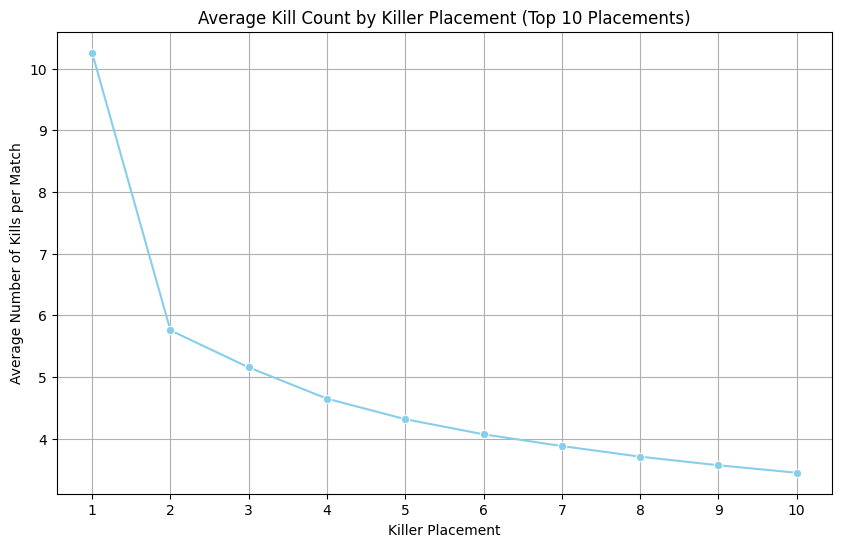

In [ ]:
# 1st Plot (line): Avg kill by killer placement

# Filter the data for the top 10 placements
top_10_placements_df = pandas_df[pandas_df['killer_placement'] <= 10]

# Calculate the average kills per match for each killer placement (up to the top 10 placements)
avg_kills_by_placement_top_10 = (
    top_10_placements_df.groupby(['killer_placement', 'match_id']).size()
    .groupby(level=0).mean()
    .reset_index(name='avg_kills')
)

# Plot the results using a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_kills_by_placement_top_10, x='killer_placement', y='avg_kills', marker='o', color='skyblue')
plt.title('Average Kill Count by Killer Placement (Top 10 Placements)')
plt.xlabel('Killer Placement')
plt.ylabel('Average Number of Kills per Match')
plt.xticks(range(1, 11, 1))
plt.grid(True)
plt.show()

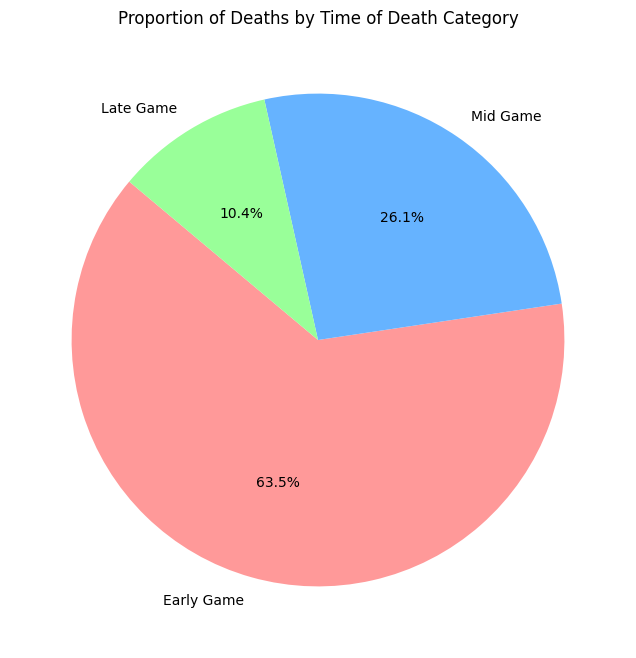

In [ ]:
# 2nd Plot (pie chart): Proportions of deaths by time of death category

# Define consistent color palette for the categories,
# since I want this plot to share colors with the one after this
category_colors = ['#ff9999', '#66b3ff', '#99ff99']

# Stackplot for Deaths by Time Category Over Time
# Count the deaths per minute and time category
time_category_counts = pandas_df.groupby([pandas_df['time'] // 60, 'time_of_death_category']).size().unstack(fill_value=0)

# Pie Chart for Proportion of Deaths by Time of Death Category
# Calculate the counts for each category
category_counts = pandas_df['time_of_death_category'].value_counts()

# Create the pie chart with consistent colors
plt.figure(figsize=(8, 8))
plt.pie(
    category_counts, 
    labels=category_counts.index, 
    autopct='%1.1f%%',   # Show percentage inside each slice
    startangle=140,      # Rotate for a better layout
    colors=category_colors  # Use the consistent color palette applied beforehand
)
plt.title('Proportion of Deaths by Time of Death Category')
plt.show()

#### **Observations**

Unsurprisingly, most of the kills happens in the Early Game (first 40% of the game), accounting for 63% of the kills on average.

Also, in the final 30% of the game, only 10% of the kills happens, which makes sense in a survival game.

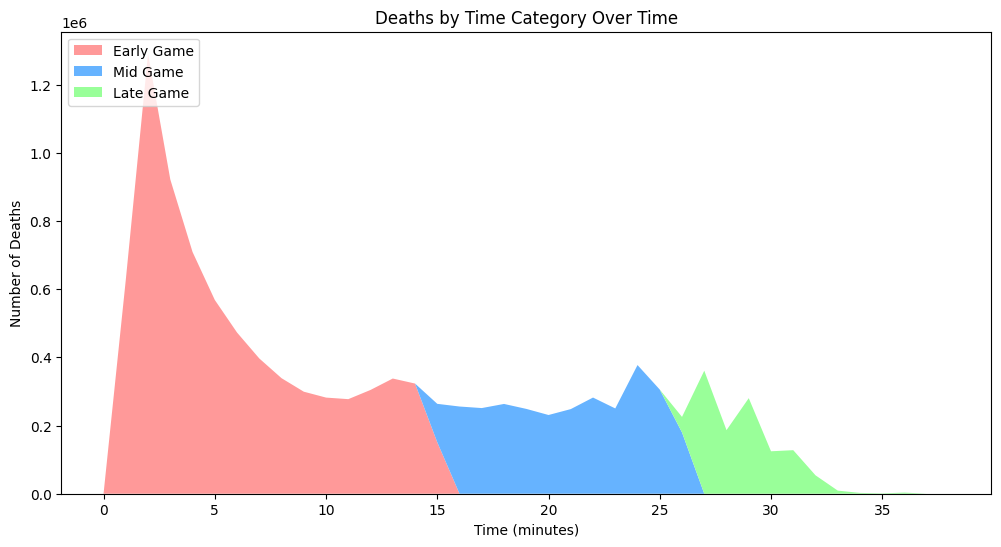

In [ ]:
# 3rd Plot (stacked area): Deaths by time category over time

plt.figure(figsize=(12, 6))
plt.stackplot(
    time_category_counts.index, 
    time_category_counts['Early Game'], 
    time_category_counts['Mid Game'], 
    time_category_counts['Late Game'], 
    labels=['Early Game', 'Mid Game', 'Late Game'], 
    colors=category_colors
)
plt.title('Deaths by Time Category Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Number of Deaths')
plt.legend(loc='upper left')
plt.show()

#### **Observations**

Here we can see a more in-depth approach of the graph above, showing now how those kills happens over time.

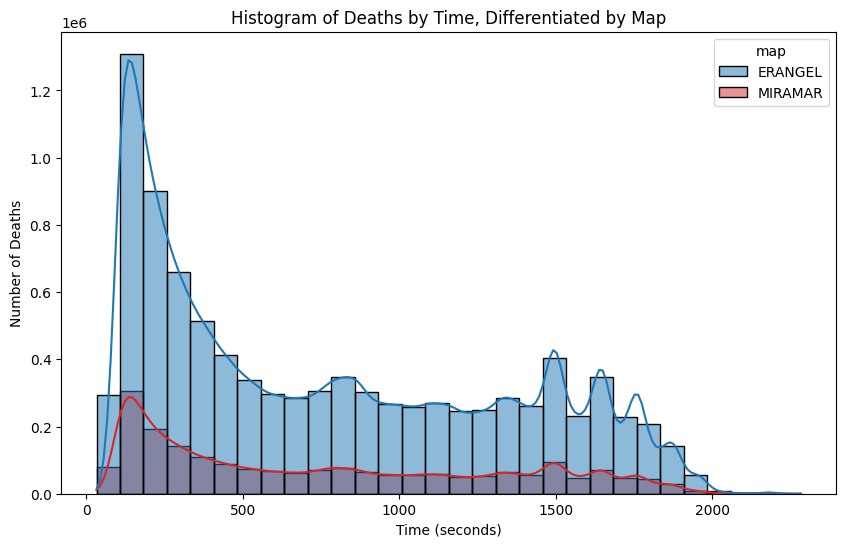

In [ ]:
# 4th Plot (histogram with tendency lines): Deaths by time, differentiated by map
 
plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x='time', hue='map', bins=30, kde=True, palette=['#1f77b4', '#d62728'])
plt.title('Histogram of Deaths by Time, Differentiated by Map')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Deaths')
plt.show()

#### **Observations**

In this histogram we can observe an even more detailed approach of the last plot, now separated by map. Interestingly, both maps share about the same distribution and peaks over time.

/var/folders/dz/zjqgg0_j2wg9vtjy2jt6v5vc0000gn/T/ipykernel_3547/2296017602.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weapon_counts.head(10), x='deaths', y='weapon', palette='coolwarm')


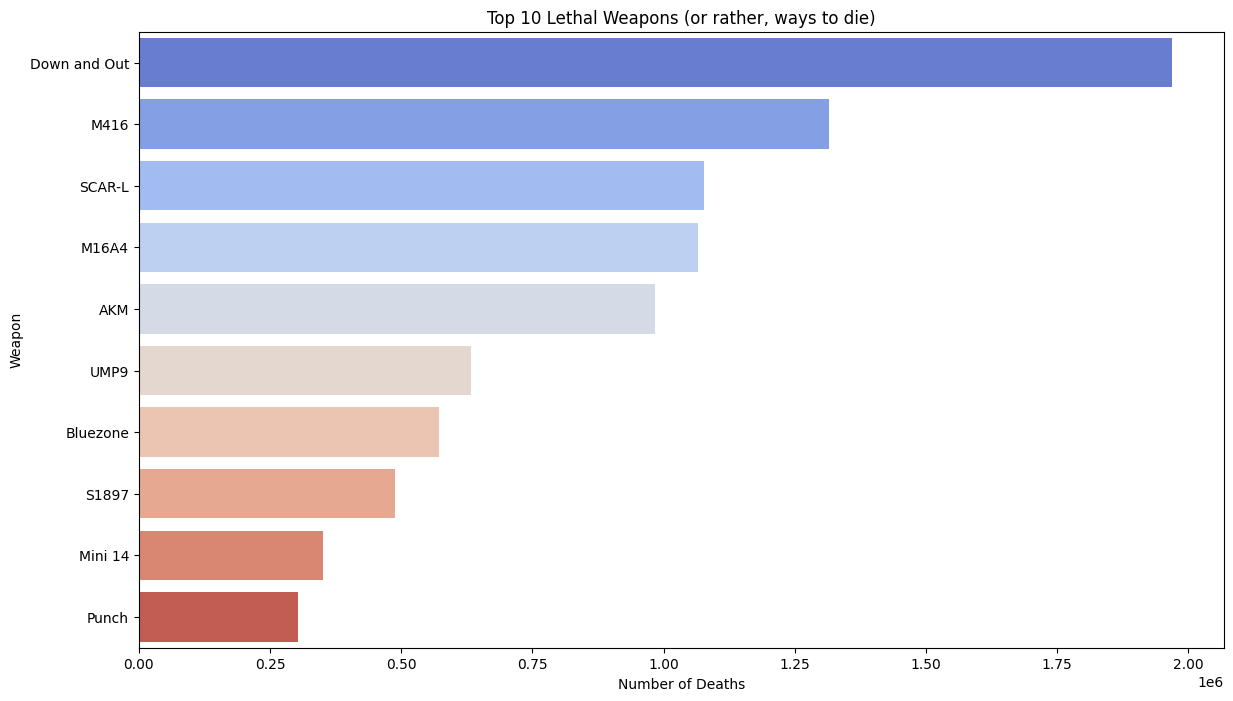

In [ ]:
# 5th Plot (horizontal bar chart): Top 10 most lethal weapons or ways to die

# Group by weapon type and count deaths
weapon_counts = pandas_df['killed_by'].value_counts().reset_index()
weapon_counts.columns = ['weapon', 'deaths']

plt.figure(figsize=(14, 8))
sns.barplot(data=weapon_counts.head(10), x='deaths', y='weapon', palette='coolwarm')
plt.title('Top 10 Lethal Weapons (or rather, ways to die)')
plt.xlabel('Number of Deaths')
plt.ylabel('Weapon')
plt.show()

#### **Observations**

**Down and Out** being the most popular way to die is expected. Since there needs to be 100 players on the game every match, a considerable amount of them are bots, and when they fight eachother, they stop shooting once one of them is *down*.

Most of the other *killed_by* values are weapons; the most popular ones are rifles, such as **M416** and **SCAR-L**, but there is a shotgun **S1897** and even barefists **Punch**.

It is also worth noting that **Bluezone** is the 7th most deadly thing to kill in this game, which is interesting considering it's a main game mechanic.

In [ ]:
# Sample a very small amount (0.1%) of the data and filter for each map separately
erangel_data = pandas_df[pandas_df['map'] == 'ERANGEL'].sample(frac=0.001)
miramar_data = pandas_df[pandas_df['map'] == 'MIRAMAR'].sample(frac=0.001)

# This is required since the following heatmap plot doesn't need the whole set of data,
# and also helps reducing clutter and improving visibility

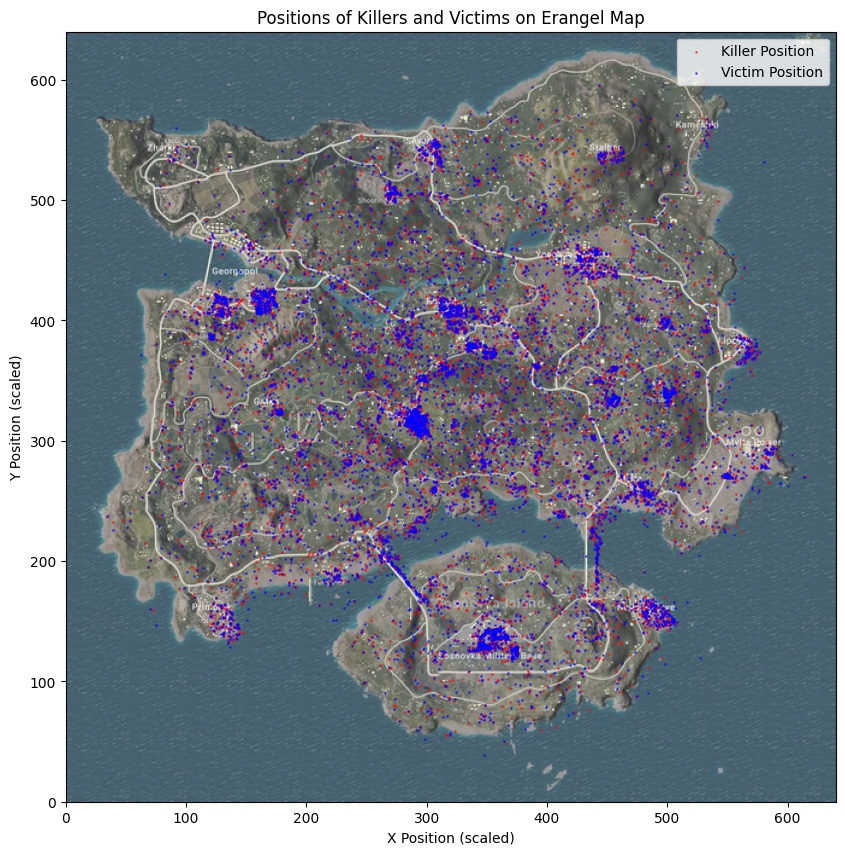

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the Erangel map image
map_img = mpimg.imread("/Users/ivantravisany/erangel.jpg")

# Scale coordinates to fit the 640x640 image
scale_factor = 640 / 800000  # Scaling from 0-800,000 (range of positions) to 0-640
erangel_data['scaled_killer_x'] = erangel_data['killer_position_x'] * scale_factor
erangel_data['scaled_killer_y'] = erangel_data['killer_position_y'] * scale_factor
erangel_data['scaled_victim_x'] = erangel_data['victim_position_x'] * scale_factor
erangel_data['scaled_victim_y'] = erangel_data['victim_position_y'] * scale_factor

plt.figure(figsize=(10, 10))

# Display the map image, adjusting the extent to cover 0 to 640 for both x and y,
# also set a little bit of transparency there
plt.imshow(map_img, extent=[0, 640, 0, 640], alpha=0.8)

# Plot killer positions
plt.scatter(erangel_data['scaled_killer_x'], 640 - erangel_data['scaled_killer_y'], 
            color='red', s=1, label='Killer Position', alpha=0.5)

# Plot victim positions
plt.scatter(erangel_data['scaled_victim_x'], 640 - erangel_data['scaled_victim_y'], 
            color='blue', s=1, label='Victim Position', alpha=0.5)

plt.title("Positions of Killers and Victims on Erangel Map")
plt.xlabel("X Position (scaled)")
plt.ylabel("Y Position (scaled)")
plt.legend(loc='upper right')
plt.show()

#### **Observations**

And finally, to make use of the player coordinates, a heatmap plot. Here we can see where the highest amount of kills happens in Erangel map which, in part, show where the best loot and weapons are located, which is also why most battles—and therefore deaths—occur there.

# 5. Machine Learning Model

### Used to predict in which category of time of the game (Early, Mid or Late) did the kill occurred, based on the position of the victim and the killer

In [ ]:
# Drop all rows with any null values in df, as explained in section 3.1
df = df.na.drop()

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# This is where I experimented with different features selection for the model
#data = df.select("normalized_time", "normalized_victim", "normalized_killer", "time_of_death_category")
data = df.select("normalized_victim", "normalized_killer", "time_of_death_category")

In [65]:
# Step 1: String indexer for time_of_death_category
indexer = StringIndexer(inputCol="time_of_death_category", outputCol="label")

In [ ]:
# Step 2: Vector assembler to combine features into a single vector
assembler = VectorAssembler(
    #inputCols=["normalized_time", "normalized_victim", "normalized_killer"],
    inputCols=["normalized_victim", "normalized_killer"],
    outputCol="features"
)

In [67]:
# Step 3: Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

In [68]:
# Step 4: Build the pipeline
pipeline = Pipeline(stages=[indexer, assembler, rf])

In [69]:
# Step 5: Split the data into train and test sets
train_df, test_df = data.randomSplit([0.8, 0.2])

In [70]:
# Step 6: Train the model
model = pipeline.fit(train_df)

In [71]:
# Step 7: Make predictions on test data
predictions = model.transform(test_df)

In [72]:
# Step 8: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Model accuracy: {accuracy}")

Model accuracy: 0.8396256080652923


#### **Observations**

TWith **84%** accuracy, this model has a good prospect for the predictions.

In [ ]:
# Additional metrics
f1_evaluator = MulticlassClassificationEvaluator(labelCol="time_of_death_category", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="time_of_death_category", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="time_of_death_category", predictionCol="prediction", metricName="weightedRecall")

In [74]:
# Define evaluators using the numeric 'label' column instead of 'time_of_death_category'
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")

# Evaluate predictions
f1_score = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.8353050509059216
Precision: 0.8876658454913604
Recall: 0.9311780944326541


#### **Observations**

For this model, all metrics shows promising scores. This model demonstrates strong performance, with high precision and recall indicating it effectively identifies positives with minimal false positives or missed cases. The balanced F1 score suggests robust, reliable predictions overall.

In [ ]:
# Step 9: Show some example predictions
#predictions.select("normalized_victim", "normalized_time", "map", "label", "prediction").show(20)
#predictions.select("normalized_time", "map", "label", "prediction").show(20)

from pyspark.sql.functions import rand

# Randomly shuffle and then show 20 rows
predictions.orderBy(rand()).select("normalized_victim", "normalized_killer", "time_of_death_category", "label", "prediction").show(20)

+--------------------+-------------------+----------------------+-----+----------+
|   normalized_victim|  normalized_killer|time_of_death_category|label|prediction|
+--------------------+-------------------+----------------------+-----+----------+
| 0.04040404040404041|                0.0|              Mid Game|  1.0|       2.0|
| 0.20202020202020202| 0.1919191919191919|            Early Game|  0.0|       0.0|
|   0.898989898989899| 0.1414141414141414|            Early Game|  0.0|       0.0|
|  0.1717171717171717| 0.1111111111111111|              Mid Game|  1.0|       0.0|
|  0.1919191919191919| 0.0707070707070707|            Early Game|  0.0|       0.0|
| 0.37373737373737376|                0.0|            Early Game|  0.0|       0.0|
| 0.04040404040404041|                0.0|             Late Game|  2.0|       2.0|
| 0.42424242424242425|0.20202020202020202|            Early Game|  0.0|       0.0|
|0.010101010101010102|0.26262626262626265|             Late Game|  2.0|       0.0|
|  0

#### **Observations**

And this is a random sample of 20 records showing some predictions, where the labels are as following:

- Early Game: 0
- Mid Game: 1
- Late Game: 2

# 6. Model Tuning

#### I was expecting to perform a deep Model Tuning, but it takes a massive amount of time to do so, particularly the iteration through the parameter grid.

#### In any case, I managed to do it only a couple of times. The only thing I missed was to keep changing the values of the grid to get to further improve the model.

In [82]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

In [ ]:
# Most of these steps are the same performed in the model #2

# Step 1: Prepare the data selecting certain features
data = df.select("normalized_victim", "normalized_killer", "time_of_death_category")

In [84]:
# Step 2: String indexer for the categorical target column
indexer = StringIndexer(inputCol="time_of_death_category", outputCol="label")

In [ ]:
# Step 3: Vector assembler to combine features into one
assembler = VectorAssembler(inputCols=["normalized_victim", "normalized_killer"], outputCol="features")

In [86]:
# Step 4: Initialize RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

In [87]:
# Step 5: Build the pipeline with stages
pipeline = Pipeline(stages=[indexer, assembler, rf])

In [88]:
# Step 6: Split the data into train and test sets
train_df, test_df = data.randomSplit([0.8, 0.2])

In [89]:
# Step 7: Set up parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.maxBins, [32, 40]) \
    .build()

In [90]:
# Step 8: Define evaluator for cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [91]:
# Step 9: Set up cross-validator with 3 folds
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
# Step 10: Train the model using cross-validation
# This step was very time consuming
cvModel = crossval.fit(train_df)

In [93]:
# Step 11: Make predictions on test data using the best model
predictions = cvModel.transform(test_df)

In [94]:
# Step 12: Evaluate the model performance
accuracy = evaluator.evaluate(predictions)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.8405355216957646


In [95]:
# Additional metrics
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

In [96]:
# Compute additional metrics
f1_score = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.8364863789734311
Precision: 0.8351775633783152
Recall: 0.8405355216957646


#### **Observations**

These results indicate that the model tuning did not significantly improve the model's performance compared to the initial model (#2), as the scores are quite close.

Some key observations:

1.	**Accuracy** and **F1 Score** are nearly identical for both models, which implies that the initial configuration was already close to optimal.
2.	**Precision** and **Recall**: The initial model achieved a higher precision and recall, suggesting that it was better at identifying true positives accurately but might have had more variance in the predictions across classes.
3.	**Balanced Performance**: The tuned model has slightly lower precision and recall than the initial model but offers a more balanced performance.

In any case, below are the best model parameters according to the model tuning phase.

In [ ]:
# Finally: Show what were the best model parameters
best_model = cvModel.bestModel.stages[-1]  # Get the RandomForest model stage from the pipeline
print(f"Best model parameters: numTrees={best_model.getNumTrees}, maxDepth={best_model.getMaxDepth()}, maxBins={best_model.getMaxBins()}")

Best model parameters: numTrees=10, maxDepth=15, maxBins=40
